In [4]:
import os 
import cv2
import numpy as np
from PIL import Image
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.activations import relu
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob as gb
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import re
from keras.preprocessing.image import img_to_array
from tqdm import tqdm
from PIL import Image
import tensorflow as tf

In [5]:
x_train_path = '/kaggle/input/landscape-image-colorization/landscape Images/gray'
y_train_path = '/kaggle/input/landscape-image-colorization/landscape Images/color'

In [6]:
gray_img=[]
color_img=[]
for img in os.listdir(x_train_path):
    image_path = os.path.join(x_train_path,img)
    g=Image.open(image_path)
    new_size = (224,224)
    resized_img = g.resize(new_size)
    gray_img.append(resized_img)
for img in os.listdir(y_train_path):
    image_path = os.path.join(y_train_path,img)
    g=Image.open(image_path)
    new_size = (224, 224)
    resized_img = g.resize(new_size)
    color_img.append(resized_img)
    

In [7]:
gray_img=np.array(gray_img)
color_img=np.array(color_img)
gray_img=np.expand_dims(gray_img,axis=-1)
gray_img=gray_img/255
color_img=color_img/255


In [8]:
train_gray_img=gray_img[:6000]
test_gray_img=gray_img[6000:]
train_color_img=color_img[:6000]
test_color_img=color_img[6000:]

In [9]:
print(train_gray_img.shape)
print(test_gray_img.shape)
print(train_color_img.shape)
print(test_color_img.shape)

(6000, 224, 224, 1)
(1129, 224, 224, 1)
(6000, 224, 224, 3)
(1129, 224, 224, 3)


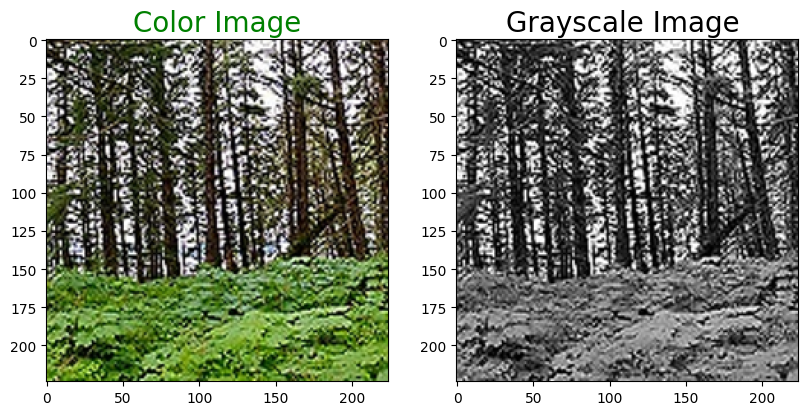

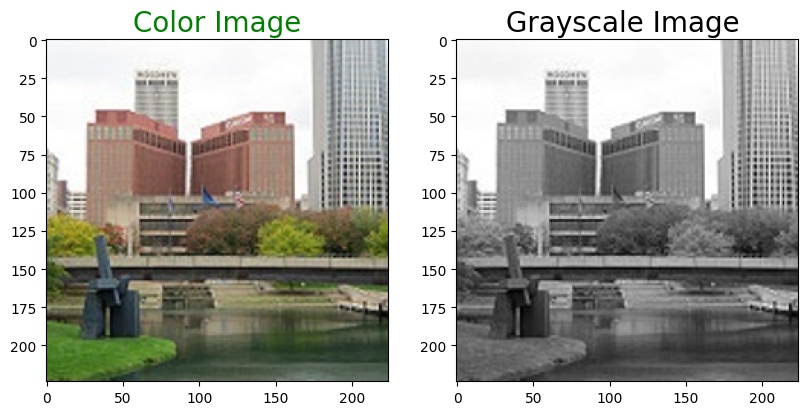

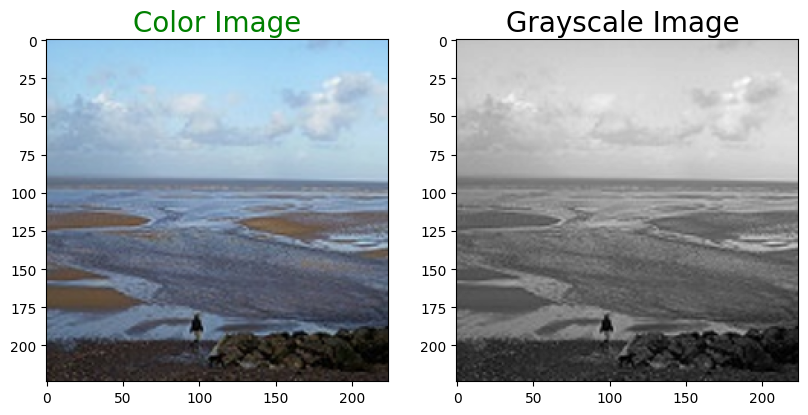

In [10]:
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale,cmap='gray')
   
    plt.show()
for i in range(3,10):
     plot_images(train_color_img[i],train_gray_img[i])

In [11]:
data_gene=ImageDataGenerator()
train_batch=data_gene.flow(
    x=train_gray_img,
    y=train_color_img,
    batch_size=32
)

In [12]:
def u_net(h=(224,224,1)):
  gg=layers.Input(shape=h)
  x= gg
  conv =[]
  f=64

  #down_sampling
  for i in range (4):
    x= layers.Conv2D(f,3,activation='relu',padding='same')(x)
    x= layers.Conv2D(f,3,activation='relu',padding='same')(x)
    x= layers.Conv2D(f,3,activation='relu',padding='same')(x)
    x = layers.Dropout(0.3)(x) 
    x= layers.BatchNormalization()(x)
    conv.append(x)
    x= layers.MaxPooling2D()(x)
    f*=2

  
  #bottle-neck
  x= layers.Conv2D(f,3,activation='relu',padding='same')(x)
  x= layers.Conv2D(f,3,activation='relu',padding='same')(x)
  x= layers.Conv2D(f,3,activation='relu',padding='same')(x)
  x= layers.BatchNormalization()(x)
  x = layers.Dropout(0.5)(x) 
  ff=512
  j= len(conv)-1
  #up-sampling
  for i in range(4):
    x=layers.Conv2DTranspose(ff,2,strides=(2,2),padding='same')(x)
    x=layers.Concatenate(axis=3)([x,conv[j]])
    x= layers.Conv2D(ff,3,activation='relu',padding='same')(x)
    x= layers.Conv2D(ff,3,activation='relu',padding='same')(x)
    ff//=2
    j-=1


  x = layers.Conv2D(64,2,padding='same',activation='relu')(x)
  output = layers.Conv2D(3,1,padding='same')(x)
  model = models.Model(inputs=gg,outputs=output)
  return model

In [ ]:
model.summary()

In [ ]:
model = u_net()
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse'])
model.fit(train_batch,batch_size=32,epochs=5)

In [12]:
predicted=model.predict(test_gray_img)


36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 209ms/step


In [13]:
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale,cmap='gray')
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

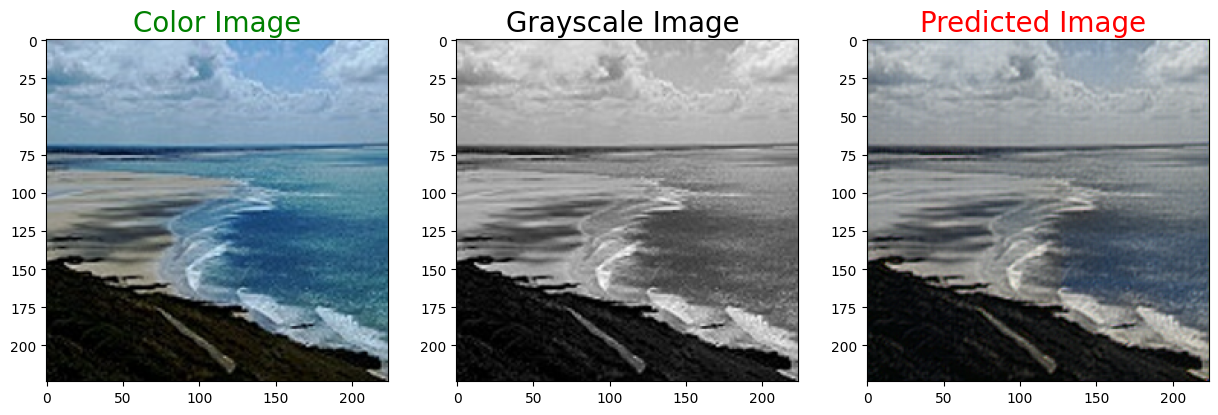

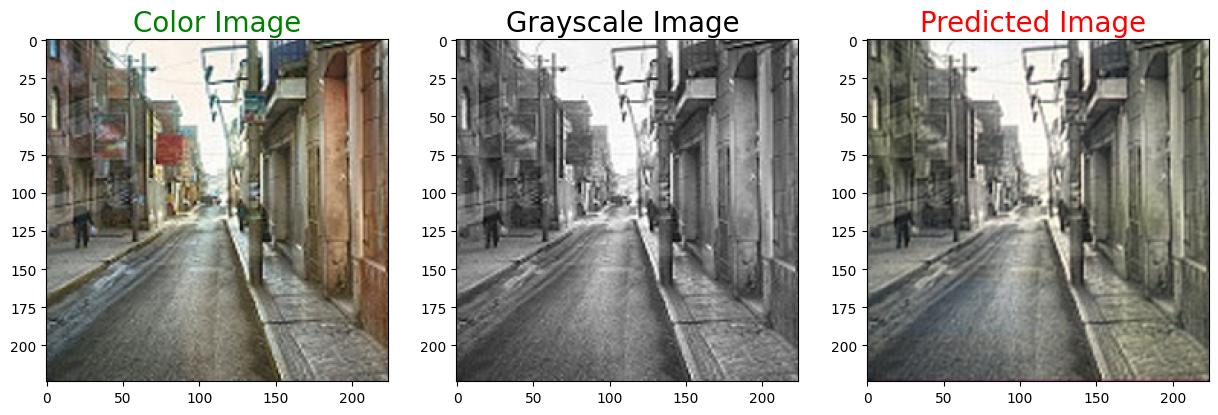

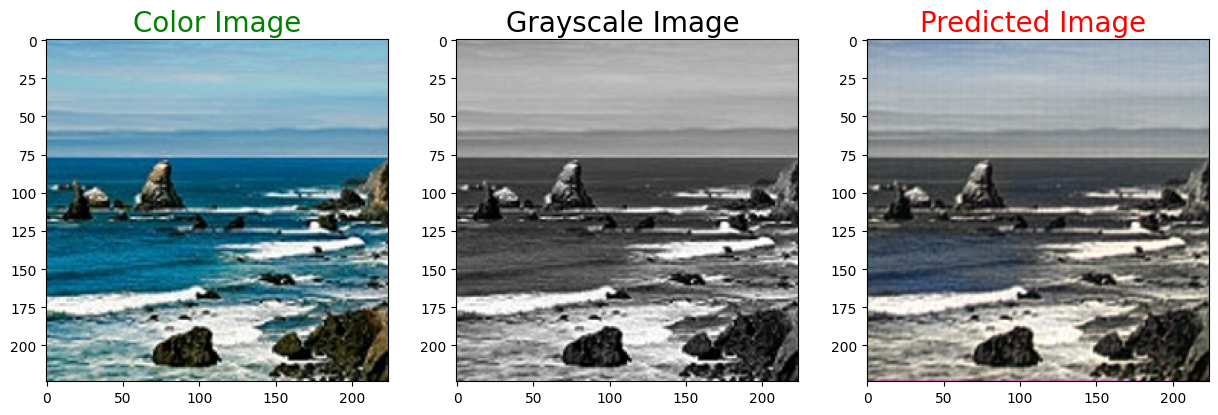

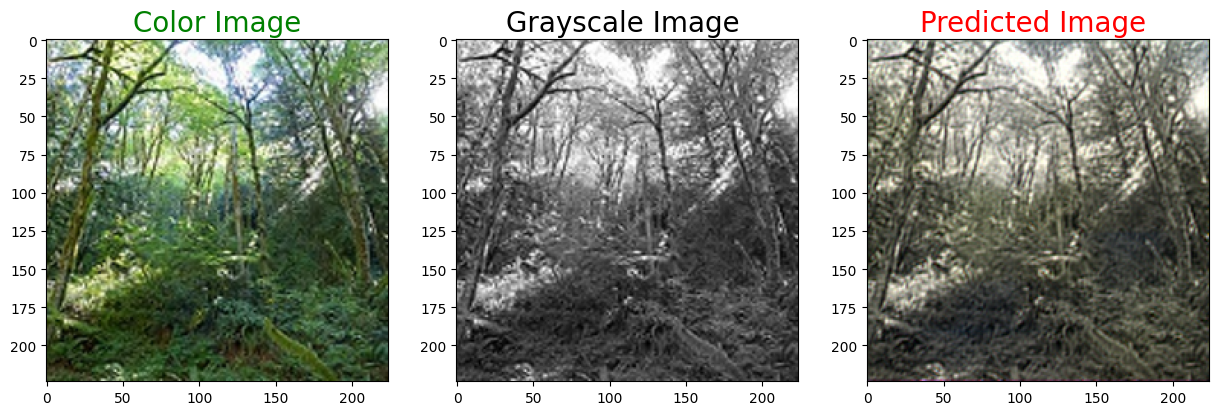

In [14]:
for i in range(100,107):
     plot_images(test_color_img[i],test_gray_img[i],predicted[i])